## Genre classification with transformers

#### Import libraries and load data from disk

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00


In [ ]:
# Импортируем необходимые библиотеки для анализа звуковых дорожек и построения моделей

import pandas as pd
import numpy as np
import librosa
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble, tree
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import tensorflow
import librosa.display
from tensorflow.keras import Input
import os
from PIL import Image
from pathlib import Path
import csv


from sklearn.metrics import accuracy_score

import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as subplots


import wandb
from wandb.sklearn import plot_precision_recall, plot_feature_importances, plot_summary_metrics
from wandb.sklearn import plot_class_proportions, plot_learning_curve, plot_roc

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Смотрим наше файловое хранилище  и выбираем из него папку с фрагментами песен
os.chdir("/content/drive/My Drive")
!ls

'1-5 вопросы.docx'
 2023_Разделение_на_минигруппы.xlsx
 5SowRbEtXrc.jpg
'A4 - Основной курс Про | Математика ОГЭ с Семёном.gsheet'
'A6 - Мастер-группа Про | Математика ОГЭ с Семёном. ЗАЧЕТЫ (Апрель).gsheet'
'A6 - Мастер-группа Про | Математика ОГЭ с Семёном. ЗАЧЕТЫ (Май) .gsheet'
'A6 - Мастер-группа Про | Математика ОГЭ с Семёном. ЗАЧЕТЫ (Март).gsheet'
'B3 - Мастер-группа Про | Математика ОГЭ с Семёном. ЗАЧЕТЫ (Апрель) .gsheet'
'B3 - Мастер-группа Про | Математика ОГЭ с Семёном. ЗАЧЕТЫ (Май).gsheet'
'B3 - Мастер-группа Про | Математика ОГЭ с Семёном. ЗАЧЕТЫ (Март) .gsheet'
 best_model_PAN.pt
 best_model.pt
 best_model.pth
 best_model_unet.pt
 cats.jpg
'Colab Notebooks'
 DATA
 data.csv
 DWH_tinkoff.txt
 e70df564-4618-11ec-bfbd-02420a0005ef.sig
 e70df564-4618-11ec-bfbd-02420a0005ef.zip
 Elephant.jpg
'F6 - Основной курс Про | Математика ОГЭ с Даниром | 2.0.gsheet'
 final_Kravchenko8В01.zip
 genres
'helper_functions (1).py'
'helper_functions (2).py'
'helper_functions (3).py'
 he

In [ ]:
import torch
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTModel

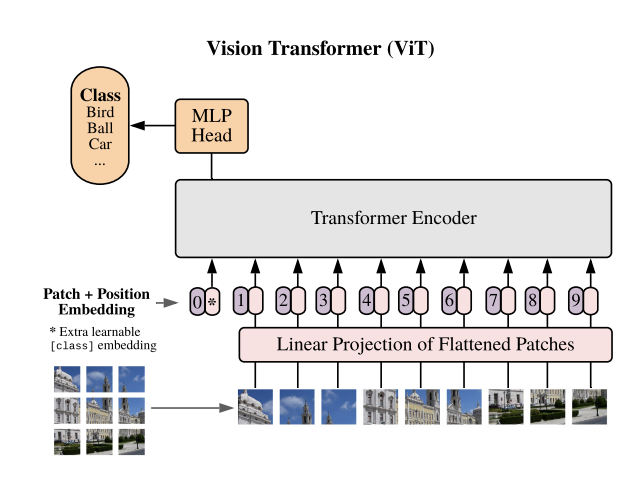

In [12]:
from PIL import Image
import requests
from io import BytesIO

url = 'https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

#### Use pretrained VitModel and tune her

In [ ]:
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4,
        'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
BATCH_SIZE = 64
NUM_EPOCHS = 100
CLASSES_COUNT = len(genres)
CLASSES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [ ]:
base_model = ViTModel.from_pretrained('google/vit-base-patch16-224')

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class ViTForCustomClassification(torch.nn.Module):
    def __init__(self, num_labels):
        super(ViTForCustomClassification, self).__init__()
        self.vit = base_model
#         self.classifier = torch.nn.Linear(base_model.config.hidden_size, num_labels)
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(base_model.config.hidden_size, 512),  # First layer
            torch.nn.ReLU(),  # Activation function
            torch.nn.Linear(512, num_labels)  # Output layer
        )

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        logits = self.classifier(outputs.last_hidden_state[:, 0])
        return logits

In [ ]:
model = ViTForCustomClassification(CLASSES_COUNT)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.nn.DataParallel(model, device_ids = [0]).to(device)

#### Tranform data, initialize paramaters

In [ ]:
torch.cuda.empty_cache()

In [ ]:
early_stopping_criteria = 10
epochs_no_improve = 0
# min_val_loss = float('inf')
max_val_accuracy = 0

In [ ]:
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [ ]:
IMAGE_WIDTH = 256 #224 нужно будет поменять
IMAGE_HEIGHT = 256 #224 нужно будет поменять
BATCH_SIZE = 64
CHANNELS = 3

In [ ]:
transform = Compose([Resize((IMAGE_HEIGHT, IMAGE_WIDTH)), ToTensor()])

In [ ]:
train_data = ImageFolder('/content/drive/My Drive/images/train', transform=transform)
val_data = ImageFolder('/content/drive/My Drive/images/valid', transform=transform)
test_data = ImageFolder('/content/drive/My Drive/images/test', transform=transform)

In [ ]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
wandb.init(project='vit_song_classification')

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
config = wandb.config
config.learning_rate = 0.0001
config.weight_decay = 0.01
config.epochs = NUM_EPOCHS
config.batch_size = BATCH_SIZE

wandb.watch(model)

[]

#### Train, validate and logging

In [ ]:
# Training loop
for epoch in range(NUM_EPOCHS):
    total_loss = 0
    total_correct = 0

    for images, labels in train_loader:
        # Move the images and labels to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = total_correct / len(train_loader.dataset)
    wandb.log({'Train Loss': avg_train_loss, 'Train Accuracy': train_accuracy})
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {avg_train_loss}, Accuracy: {train_accuracy}')

    # Append the loss and accuracy to the lists
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        total_correct = 0

        for images, labels in val_loader:
            # Move the images and labels to the GPU if available
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()

            # Calculate the number of correct predictions
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()


        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = total_correct / len(val_loader.dataset)
        wandb.log({'Validation Loss': avg_val_loss, 'Validation Accuracy': val_accuracy})
        print(f'Validation Loss: {avg_val_loss}, Accuracy: {val_accuracy}')

    # Append the loss and accuracy to the lists
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

#     # If the validation loss is at a minimum
#     if avg_val_loss < min_val_loss:
#         # Save the model
#         torch.save(model.state_dict(), 'best_model.pth')
#         epochs_no_improve = 0
#         min_val_loss = avg_val_loss
#     else:
#         epochs_no_improve += 1
#         # Check early stopping condition
#         if epochs_no_improve == early_stopping_criteria:
#             print('Early stopping!')
#             break

    # If the validation accuracy is at a maximum
    if val_accuracy > max_val_accuracy:
        # Save the model
        torch.save(model.state_dict(), 'best_model.pth')
        epochs_no_improve = 0
        max_val_accuracy = val_accuracy
    else:
        epochs_no_improve += 1
        # Check early stopping condition
        if epochs_no_improve == early_stopping_criteria:
            print('Early stopping!')
            break

    # Step the scheduler
    scheduler.step(avg_val_loss)

    model.train()

Epoch 1/100, Loss: 2.1012788911660514, Accuracy: 0.30704225352112674
Validation Loss: 1.9501137137413025, Accuracy: 0.355
Epoch 2/100, Loss: 1.7342246174812317, Accuracy: 0.43380281690140843
Validation Loss: 1.7080241441726685, Accuracy: 0.495
Epoch 3/100, Loss: 1.429789404074351, Accuracy: 0.5746478873239437
Validation Loss: 1.726877599954605, Accuracy: 0.49
Epoch 4/100, Loss: 1.2162617643674214, Accuracy: 0.6140845070422535
Validation Loss: 1.4855108857154846, Accuracy: 0.46
Epoch 5/100, Loss: 1.0523287405570347, Accuracy: 0.6901408450704225
Validation Loss: 1.6295720934867859, Accuracy: 0.475
Epoch 6/100, Loss: 0.9924658139546713, Accuracy: 0.6859154929577465
Validation Loss: 1.3821629285812378, Accuracy: 0.515
Epoch 7/100, Loss: 0.7063986683885256, Accuracy: 0.7774647887323943
Validation Loss: 1.5081658959388733, Accuracy: 0.545
Epoch 8/100, Loss: 0.5270972847938538, Accuracy: 0.8492957746478873
Validation Loss: 1.3060477674007416, Accuracy: 0.55
Epoch 9/100, Loss: 0.40804620956381

#### Visualize results

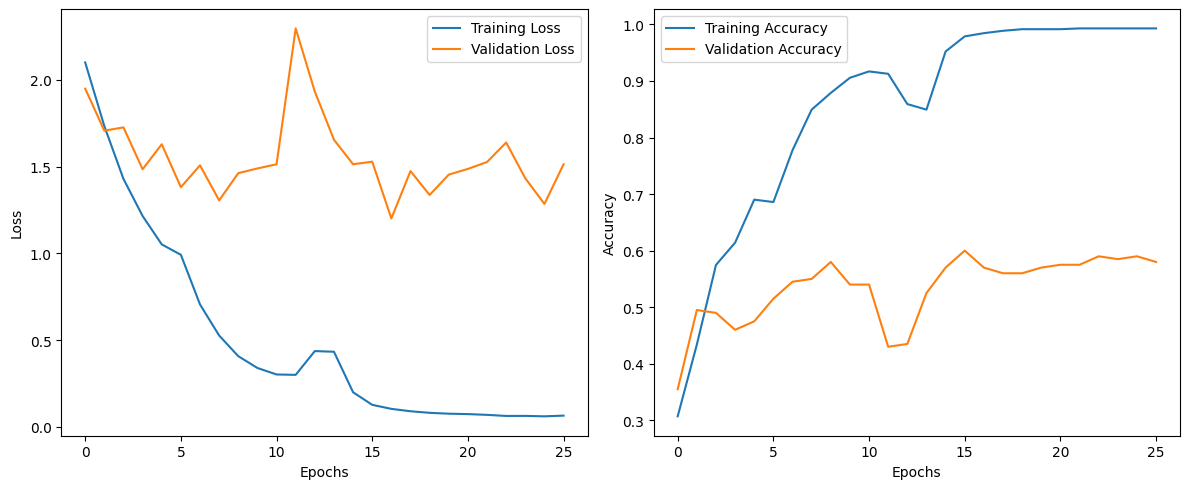

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

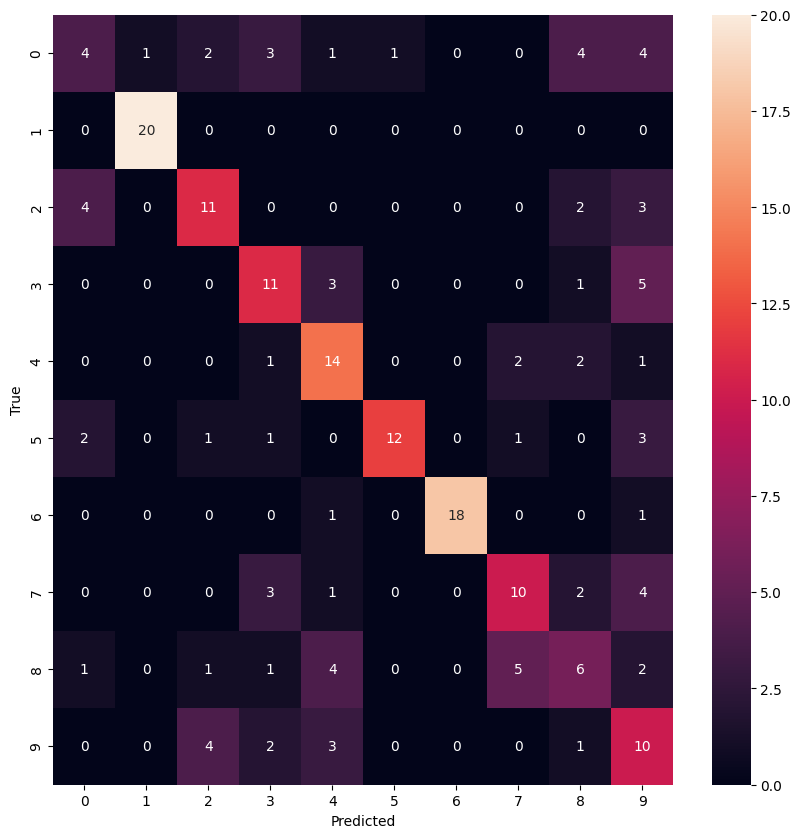

In [ ]:
model.eval()
with torch.no_grad():
    all_preds = []
    all_labels = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)

# Log the confusion matrix to wandb
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
wandb.log({'confusion_matrix': wandb.Image(fig)})

In [ ]:
def display_predictions(model, data_loader):
    model.eval()
    fig, axs = plt.subplots(5, 5, figsize=(12, 12))

    all_images = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_images.extend(images.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            if len(all_images) >= 25:
                break

    for i in range(25):
        ax = axs[i // 5, i % 5]
        ax.imshow(all_images[i].transpose((1, 2, 0)))  # Assumes images are in [C, H, W] format
        ax.axis('off')

        # If the prediction is correct, set the title to green, otherwise set it to red
        color = 'green' if all_preds[i] == all_labels[i] else 'red'
        ax.set_title(f'TRUE: {CLASSES[all_labels[i]]}\nPREDICTION: {CLASSES[all_preds[i]]}', color=color)

    plt.tight_layout()
    plt.show()

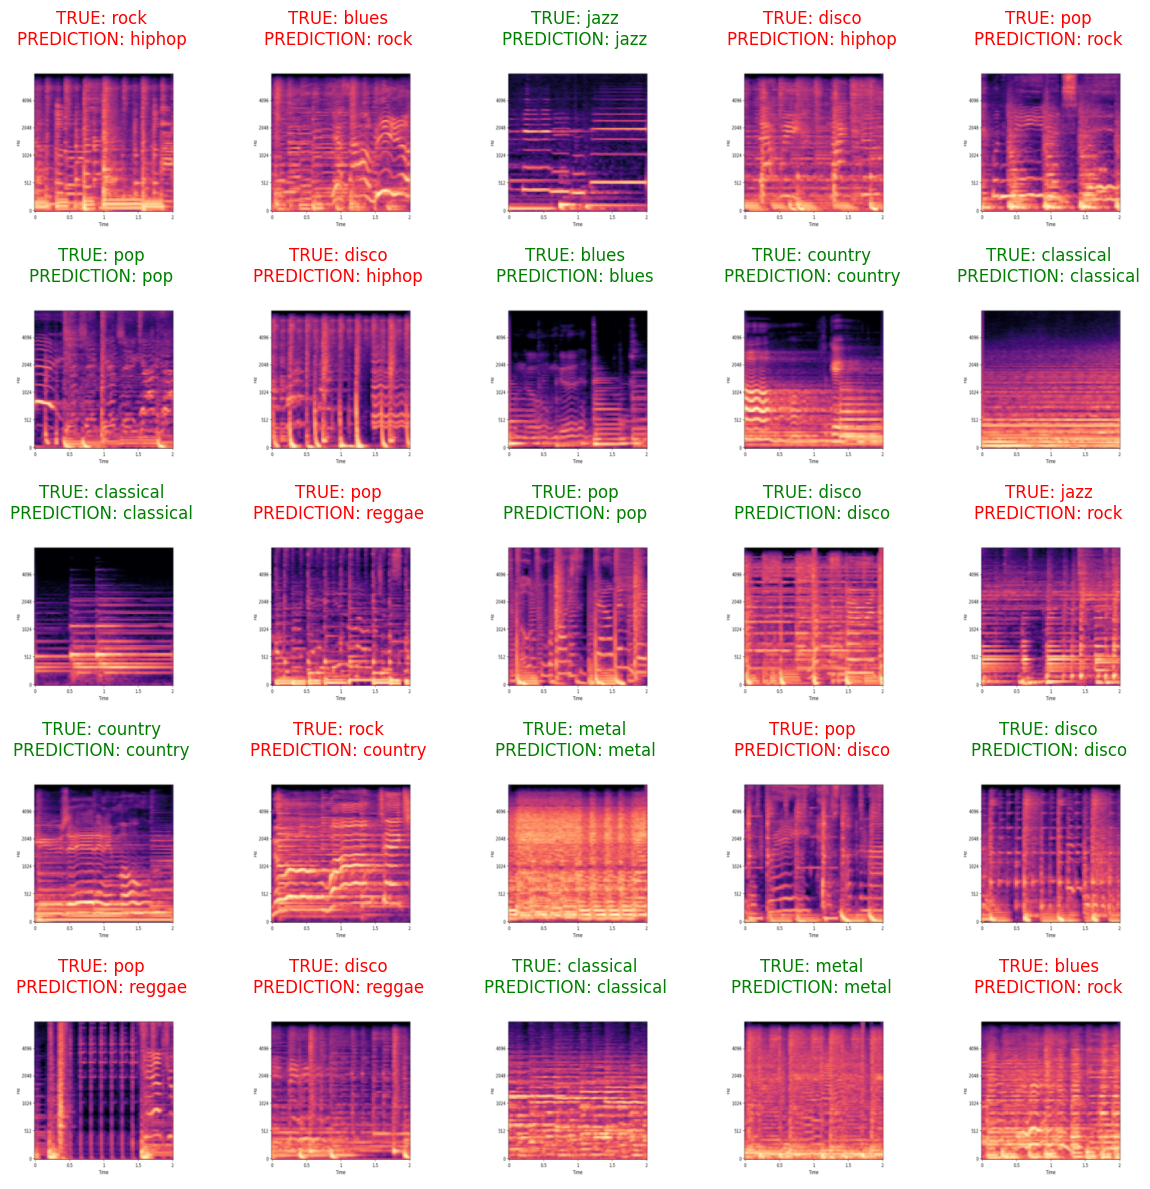

In [ ]:
display_predictions(model, val_loader)

### Let's do the same steps with BeiT


In [ ]:
from transformers import BeitForImageClassification
base_model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224')

config.json:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/350M [00:00<?, ?B/s]

In [13]:
from PIL import Image
import requests
from io import BytesIO

url = 'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/beit_architecture.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
class BeiTForCustomClassification(torch.nn.Module):
    def __init__(self, num_labels):
        super(BeiTForCustomClassification, self).__init__()
        self.beit = base_model
        self.classifier = torch.nn.Linear(base_model.config.hidden_size, num_labels)

    def forward(self, pixel_values):
        outputs = self.beit(pixel_values=pixel_values)
        return outputs.logits

In [ ]:
model = BeiTForCustomClassification(CLASSES_COUNT)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.nn.DataParallel(model, device_ids = [0]).to(device)

In [ ]:
config = wandb.config
config.learning_rate = 0.0001
config.weight_decay = 0.01
config.epochs = NUM_EPOCHS
config.batch_size = BATCH_SIZE

wandb.watch(model)

[]

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model

DataParallel(
  (module): BeiTForCustomClassification(
    (beit): BeitForImageClassification(
      (beit): BeitModel(
        (embeddings): BeitEmbeddings(
          (patch_embeddings): BeitPatchEmbeddings(
            (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): BeitEncoder(
          (layer): ModuleList(
            (0): BeitLayer(
              (attention): BeitAttention(
                (attention): BeitSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=False)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                  (relative_position_bias): BeitRelativePositionBias()
                )
                (output): BeitSelfOutput(
                  (dense): L

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.nn.DataParallel(model, device_ids = [0]).to(device)

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
early_stopping_criteria = 5
epochs_no_improve = 0
# min_val_loss = float('inf')
max_val_accuracy = 0

In [ ]:
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [ ]:
wandb.init(project='beit_song_classification')

In [ ]:
# Training loop
for epoch in range(NUM_EPOCHS):
    total_loss = 0
    total_correct = 0

    for images, labels in train_loader:
        # Move the images and labels to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(pixel_values=images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = total_correct / len(train_loader.dataset)
    wandb.log({'Train Loss': avg_train_loss, 'Train Accuracy': train_accuracy})
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {avg_train_loss}, Accuracy: {train_accuracy}')

    # Append the loss and accuracy to the lists
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        total_correct = 0

        for images, labels in val_loader:
            # Move the images and labels to the GPU if available
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(pixel_values=images)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()

            # Calculate the number of correct predictions
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()


        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = total_correct / len(val_loader.dataset)
        wandb.log({'Validation Loss': avg_val_loss, 'Validation Accuracy': val_accuracy})
        print(f'Validation Loss: {avg_val_loss}, Accuracy: {val_accuracy}')

    # Append the loss and accuracy to the lists
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # If the validation accuracy is at a maximum
    if val_accuracy > max_val_accuracy:
        # Save the model
        torch.save(model.state_dict(), 'best_model_beit.pth')
        epochs_no_improve = 0
        max_val_accuracy = val_accuracy
    else:
        epochs_no_improve += 1
        # Check early stopping condition
        if epochs_no_improve == early_stopping_criteria:
            print('Early stopping!')
            break

    # Step the scheduler
    scheduler.step(avg_val_loss)

    model.train()

Epoch 1/100, Loss: 4.3570168018341064, Accuracy: 0.1056338028169014
Validation Loss: 2.656644105911255, Accuracy: 0.125
Epoch 2/100, Loss: 2.230803350607554, Accuracy: 0.24084507042253522
Validation Loss: 2.5465253591537476, Accuracy: 0.295
Epoch 3/100, Loss: 2.0127502183119454, Accuracy: 0.3183098591549296
Validation Loss: 2.054420441389084, Accuracy: 0.3
Epoch 4/100, Loss: 1.8097024659315746, Accuracy: 0.3408450704225352
Validation Loss: 2.0973097681999207, Accuracy: 0.26
Epoch 5/100, Loss: 1.651747723420461, Accuracy: 0.4140845070422535
Validation Loss: 1.72713303565979, Accuracy: 0.365
Epoch 6/100, Loss: 1.3864973882834117, Accuracy: 0.4915492957746479
Validation Loss: 1.9252368211746216, Accuracy: 0.34
Epoch 7/100, Loss: 1.3249732851982117, Accuracy: 0.5112676056338028
Validation Loss: 1.697446048259735, Accuracy: 0.4
Epoch 8/100, Loss: 1.1881544192632039, Accuracy: 0.576056338028169
Validation Loss: 1.395574301481247, Accuracy: 0.51
Epoch 9/100, Loss: 1.0169304013252258, Accuracy

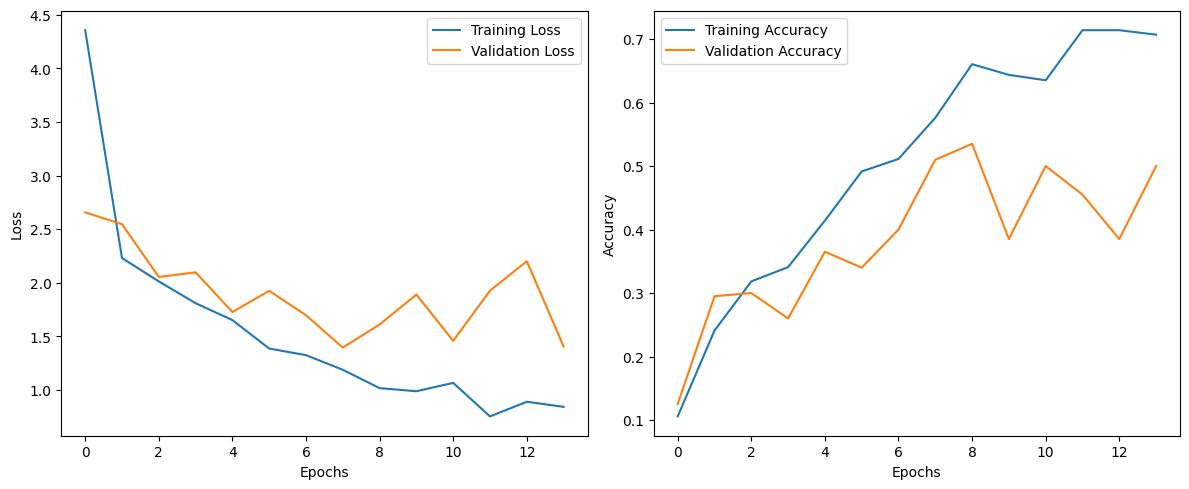

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

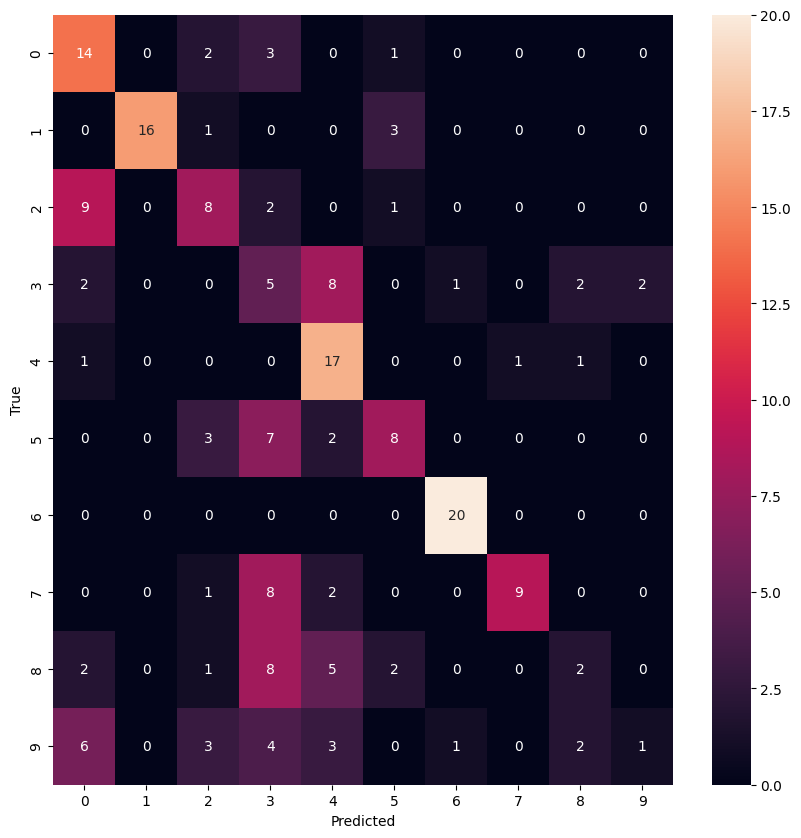

In [ ]:
model.eval()
with torch.no_grad():
    all_preds = []
    all_labels = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)

# Log the confusion matrix to wandb
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
wandb.log({'confusion_matrix': wandb.Image(fig)})

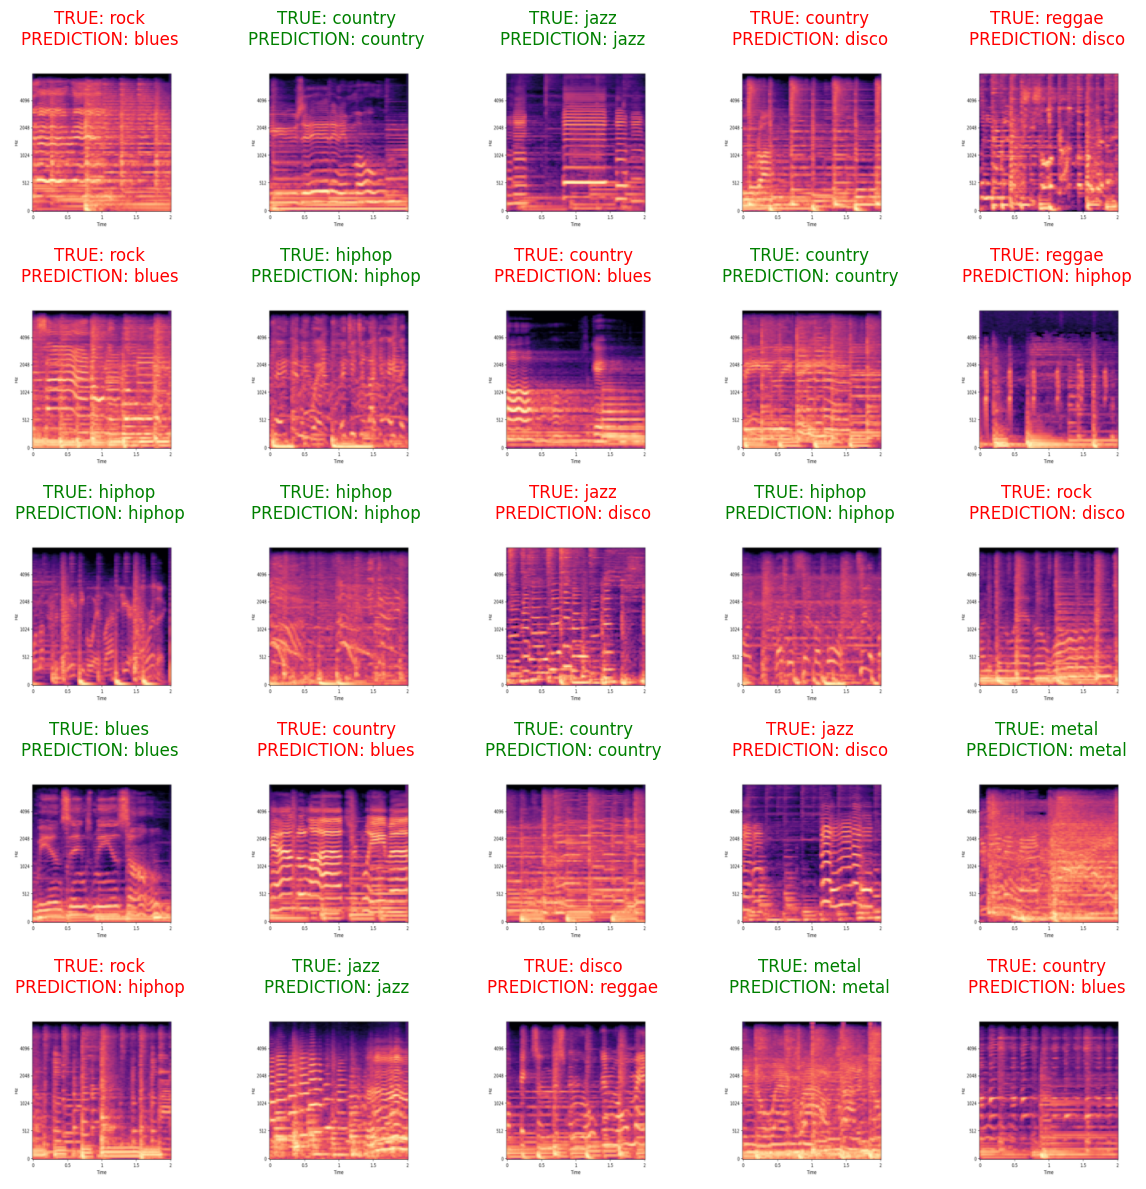

In [ ]:
display_predictions(model, val_loader)

### Let's do the same steps with MobileViT

In [ ]:
!pip install vit_pytorch -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.6/117.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.9 MB/s eta 0:00:00


In [ ]:
from vit_pytorch.mobile_vit import MobileViT

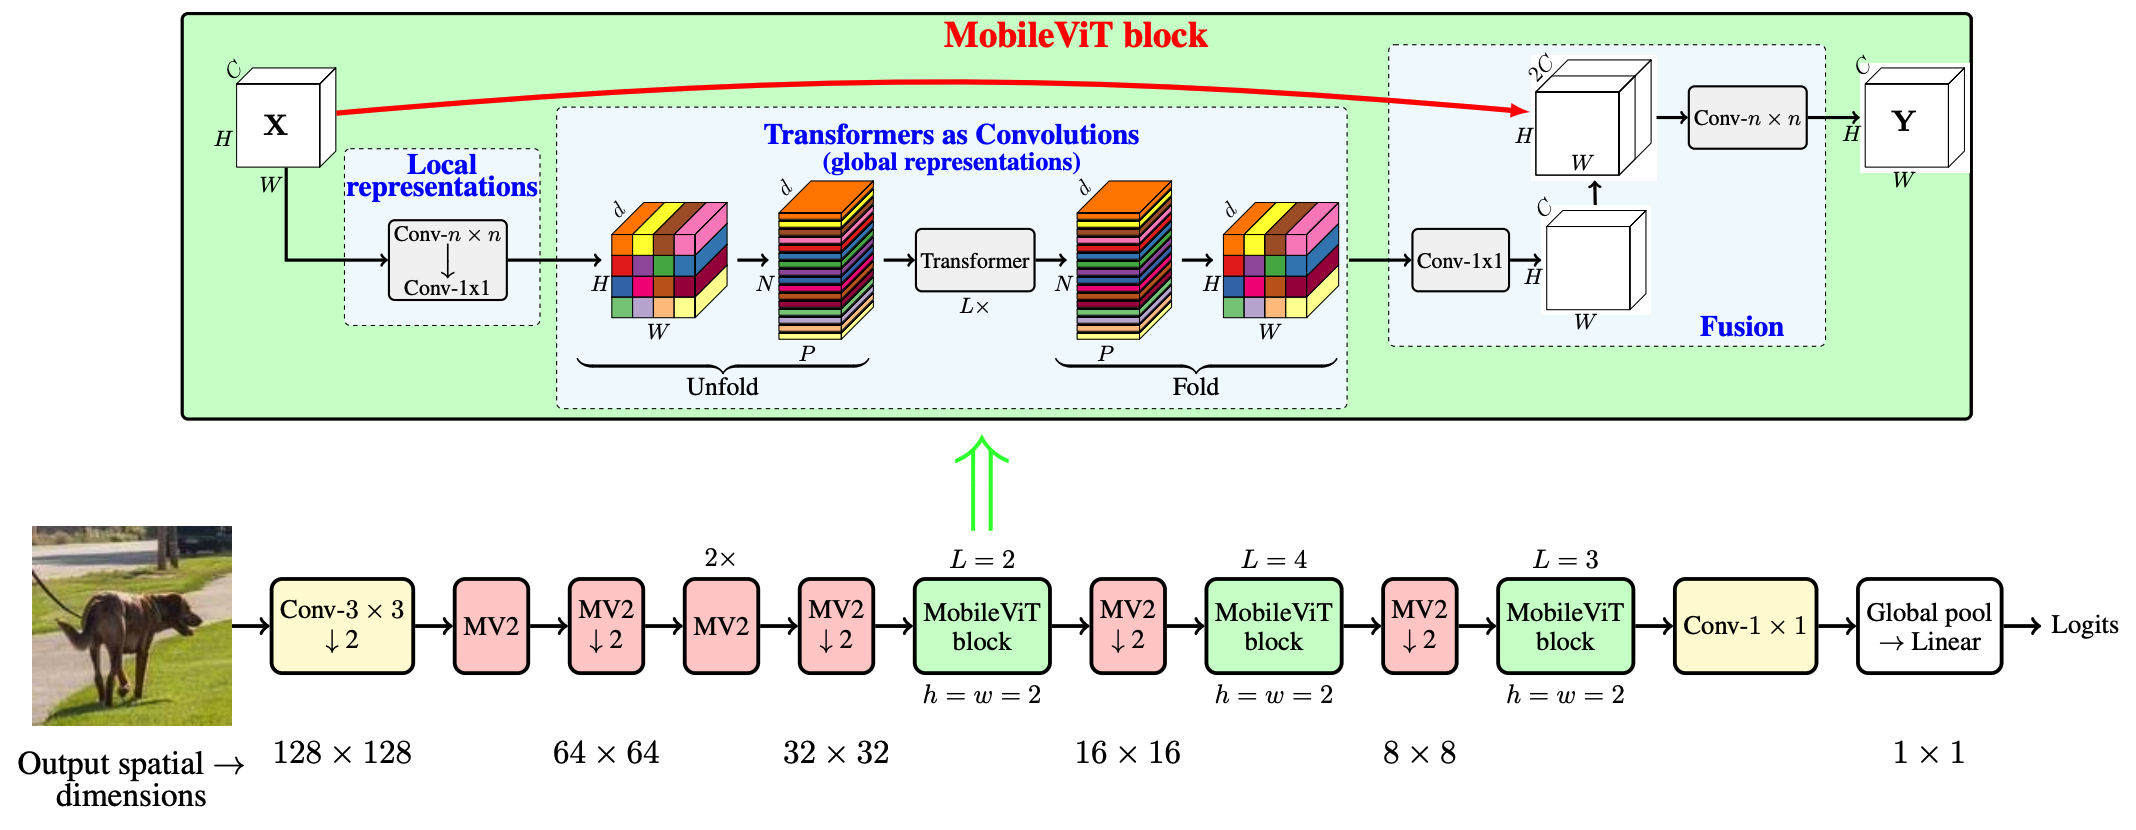

In [14]:
from PIL import Image
import requests
from io import BytesIO

url = 'https://user-images.githubusercontent.com/67839539/136470152-2573529e-1a24-4494-821d-70eb4647a51d.png'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

In [ ]:
mbvit_xs = MobileViT(
    image_size = (256, 256),
    dims = [96, 120, 144],
    channels = [16, 32, 48, 48, 64, 64, 80, 80, 96, 96, 384],
    num_classes = 10
)

In [ ]:
mbvit_xs

MobileViT(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
  )
  (stem): ModuleList(
    (0): MV2Block(
      (conv): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): SiLU()
        (6): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MV2Block(
      (conv): Sequential(
        (0): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False

In [ ]:
wandb.init(project='MobileVit_song_classification')

In [ ]:
wandb.watch(mbvit_xs)

[]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mbvit_xs = torch.nn.DataParallel(mbvit_xs, device_ids = [0]).to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.Adam(mbvit_xs.parameters(), lr=0.0001, weight_decay=0.01)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
early_stopping_criteria = 10
epochs_no_improve = 0
# min_val_loss = float('inf')
max_val_accuracy = 0

In [ ]:
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [ ]:
# Training loop
for epoch in range(NUM_EPOCHS):
    total_loss = 0
    total_correct = 0

    for images, labels in train_loader:
        # Move the images and labels to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = mbvit_xs(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = total_correct / len(train_loader.dataset)
    wandb.log({'Train Loss': avg_train_loss, 'Train Accuracy': train_accuracy})
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {avg_train_loss}, Accuracy: {train_accuracy}')

    # Append the loss and accuracy to the lists
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    mbvit_xs.eval()
    with torch.no_grad():
        total_val_loss = 0
        total_correct = 0

        for images, labels in val_loader:
            # Move the images and labels to the GPU if available
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = mbvit_xs(images)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()

            # Calculate the number of correct predictions
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()


        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = total_correct / len(val_loader.dataset)
        wandb.log({'Validation Loss': avg_val_loss, 'Validation Accuracy': val_accuracy})
        print(f'Validation Loss: {avg_val_loss}, Accuracy: {val_accuracy}')

    # Append the loss and accuracy to the lists
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # If the validation accuracy is at a maximum
    if val_accuracy > max_val_accuracy:
        # Save the model
        torch.save(mbvit_xs.state_dict(), 'best_model_MobileVit.pth')
        epochs_no_improve = 0
        max_val_accuracy = val_accuracy
    else:
        epochs_no_improve += 1
        # Check early stopping condition
        if epochs_no_improve == early_stopping_criteria:
            print('Early stopping!')
            break

    # Step the scheduler
    scheduler.step(avg_val_loss)

    mbvit_xs.train()

Epoch 1/100, Loss: 2.2255158027013144, Accuracy: 0.2619718309859155
Validation Loss: 2.3179442286491394, Accuracy: 0.1
Epoch 2/100, Loss: 1.9451283117135365, Accuracy: 0.3676056338028169
Validation Loss: 2.4115399718284607, Accuracy: 0.1
Epoch 3/100, Loss: 1.683424303929011, Accuracy: 0.4422535211267606
Validation Loss: 2.5192397236824036, Accuracy: 0.1
Epoch 4/100, Loss: 1.4636075794696808, Accuracy: 0.532394366197183
Validation Loss: 2.9507073760032654, Accuracy: 0.18
Epoch 5/100, Loss: 1.2489561935265858, Accuracy: 0.6408450704225352
Validation Loss: 3.002103090286255, Accuracy: 0.265
Epoch 6/100, Loss: 0.9802080790201823, Accuracy: 0.7774647887323943
Validation Loss: 2.1749498546123505, Accuracy: 0.345
Epoch 7/100, Loss: 0.7985514253377914, Accuracy: 0.8323943661971831
Validation Loss: 2.2141518592834473, Accuracy: 0.33
Epoch 8/100, Loss: 0.7019962767759959, Accuracy: 0.8577464788732394
Validation Loss: 1.7278365194797516, Accuracy: 0.42
Epoch 9/100, Loss: 0.5049163177609444, Accur

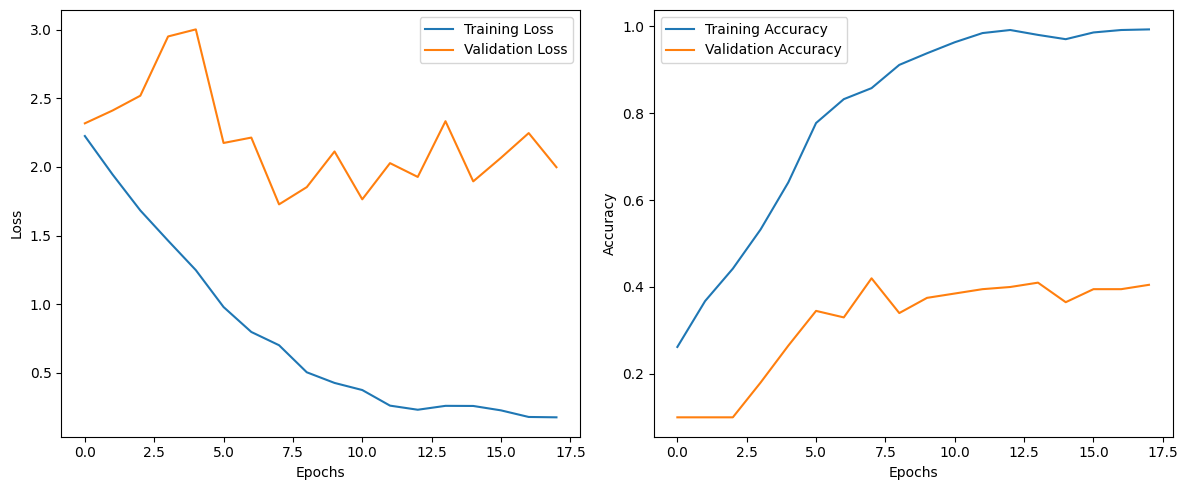

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

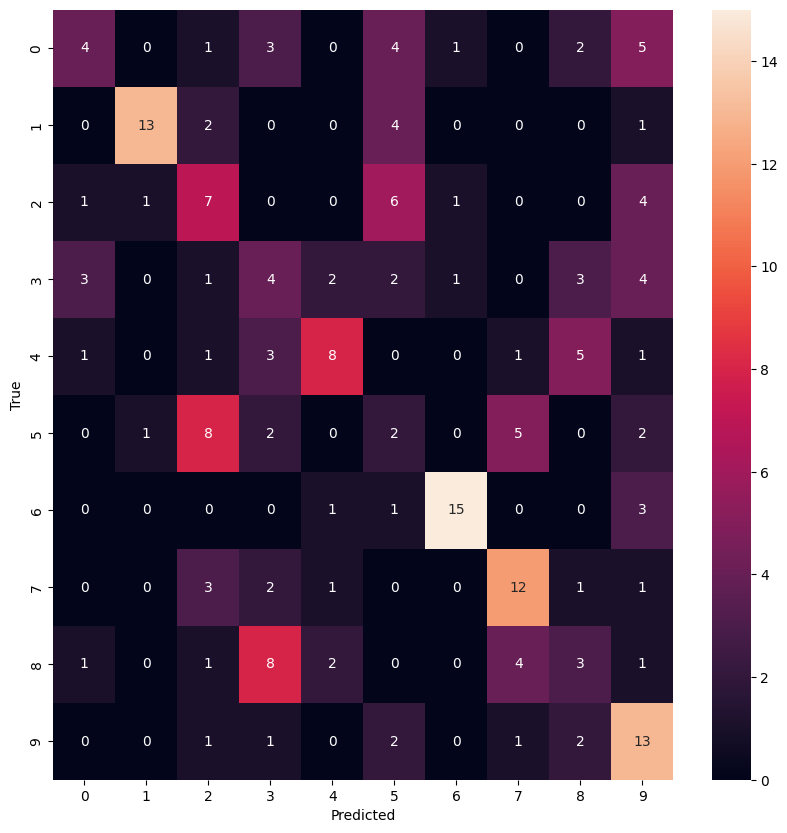

In [ ]:
mbvit_xs.eval()
with torch.no_grad():
    all_preds = []
    all_labels = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = mbvit_xs(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)

# Log the confusion matrix to wandb
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
wandb.log({'confusion_matrix': wandb.Image(fig)})

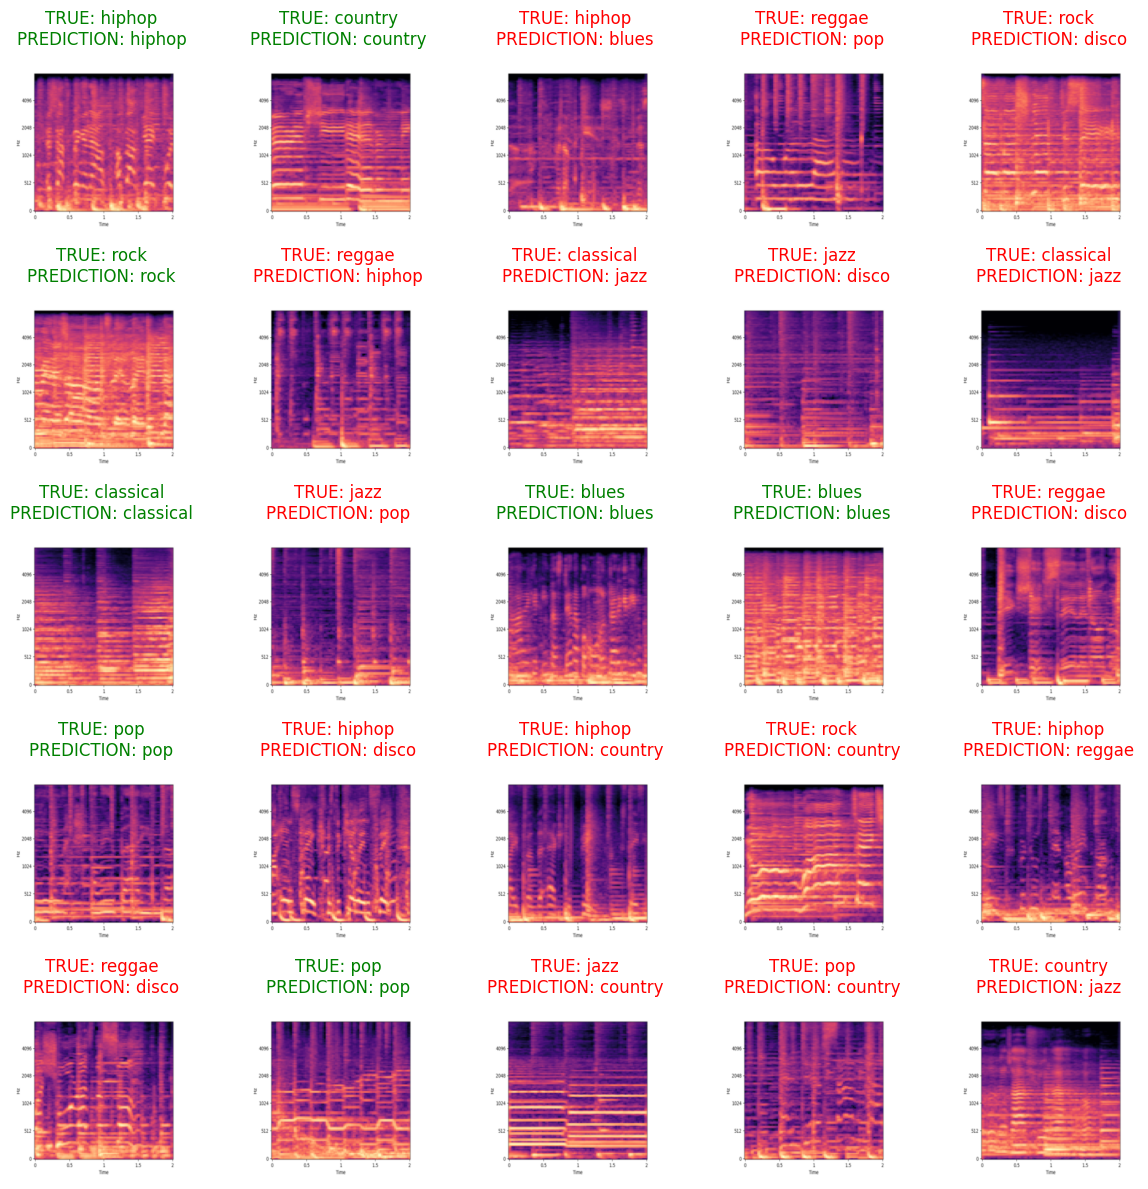

In [ ]:
display_predictions(mbvit_xs, val_loader)

### In conclusion would to say, that transformers show weak experience for our task